In [1]:
import os
import cv2
import glob
import torch
import zipfile
import random
import evaluate
import requests

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from dataclasses import dataclass

from datasets import Dataset, Image as HFImage

from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    EvalPrediction,
    TrainingArguments,
    Trainer,
)


from torchvision.transforms import v2

In [2]:
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        with zipfile.ZipFile(save_path) as z:
            z.extractall(os.path.split(save_path)[0])  # Unzip where downloaded.
            print("Done")
    except:
        print("Invalid file")

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE: int = 12
    EPOCHS: float = 5.0
    LEARNING_RATE: float = 1e-5
    WEIGHT_DECAY: float = 1e-5
    NUM_WORKERS: int = 14
    REPORT: str = "wandb"
    CACHE_DIR: str = "/teamspace/studios/this_studio/.cache"
    ROOT_DIR: str = "/teamspace/studios/this_studio"
    DATASET_DIR: str = "/teamspace/lightning_storage/ocr"

In [4]:
dataset_name = "scut_data"
dataset_zip_path = os.path.join(TrainingConfig.DATASET_DIR, f"{dataset_name}.zip")
dataset_path = os.path.join(TrainingConfig.DATASET_DIR, dataset_name)

# Download if dataset does not exists.
if not os.path.exists(dataset_path):
    download_and_unzip(os.environ["OCR"], dataset_zip_path)

## Data Exploration

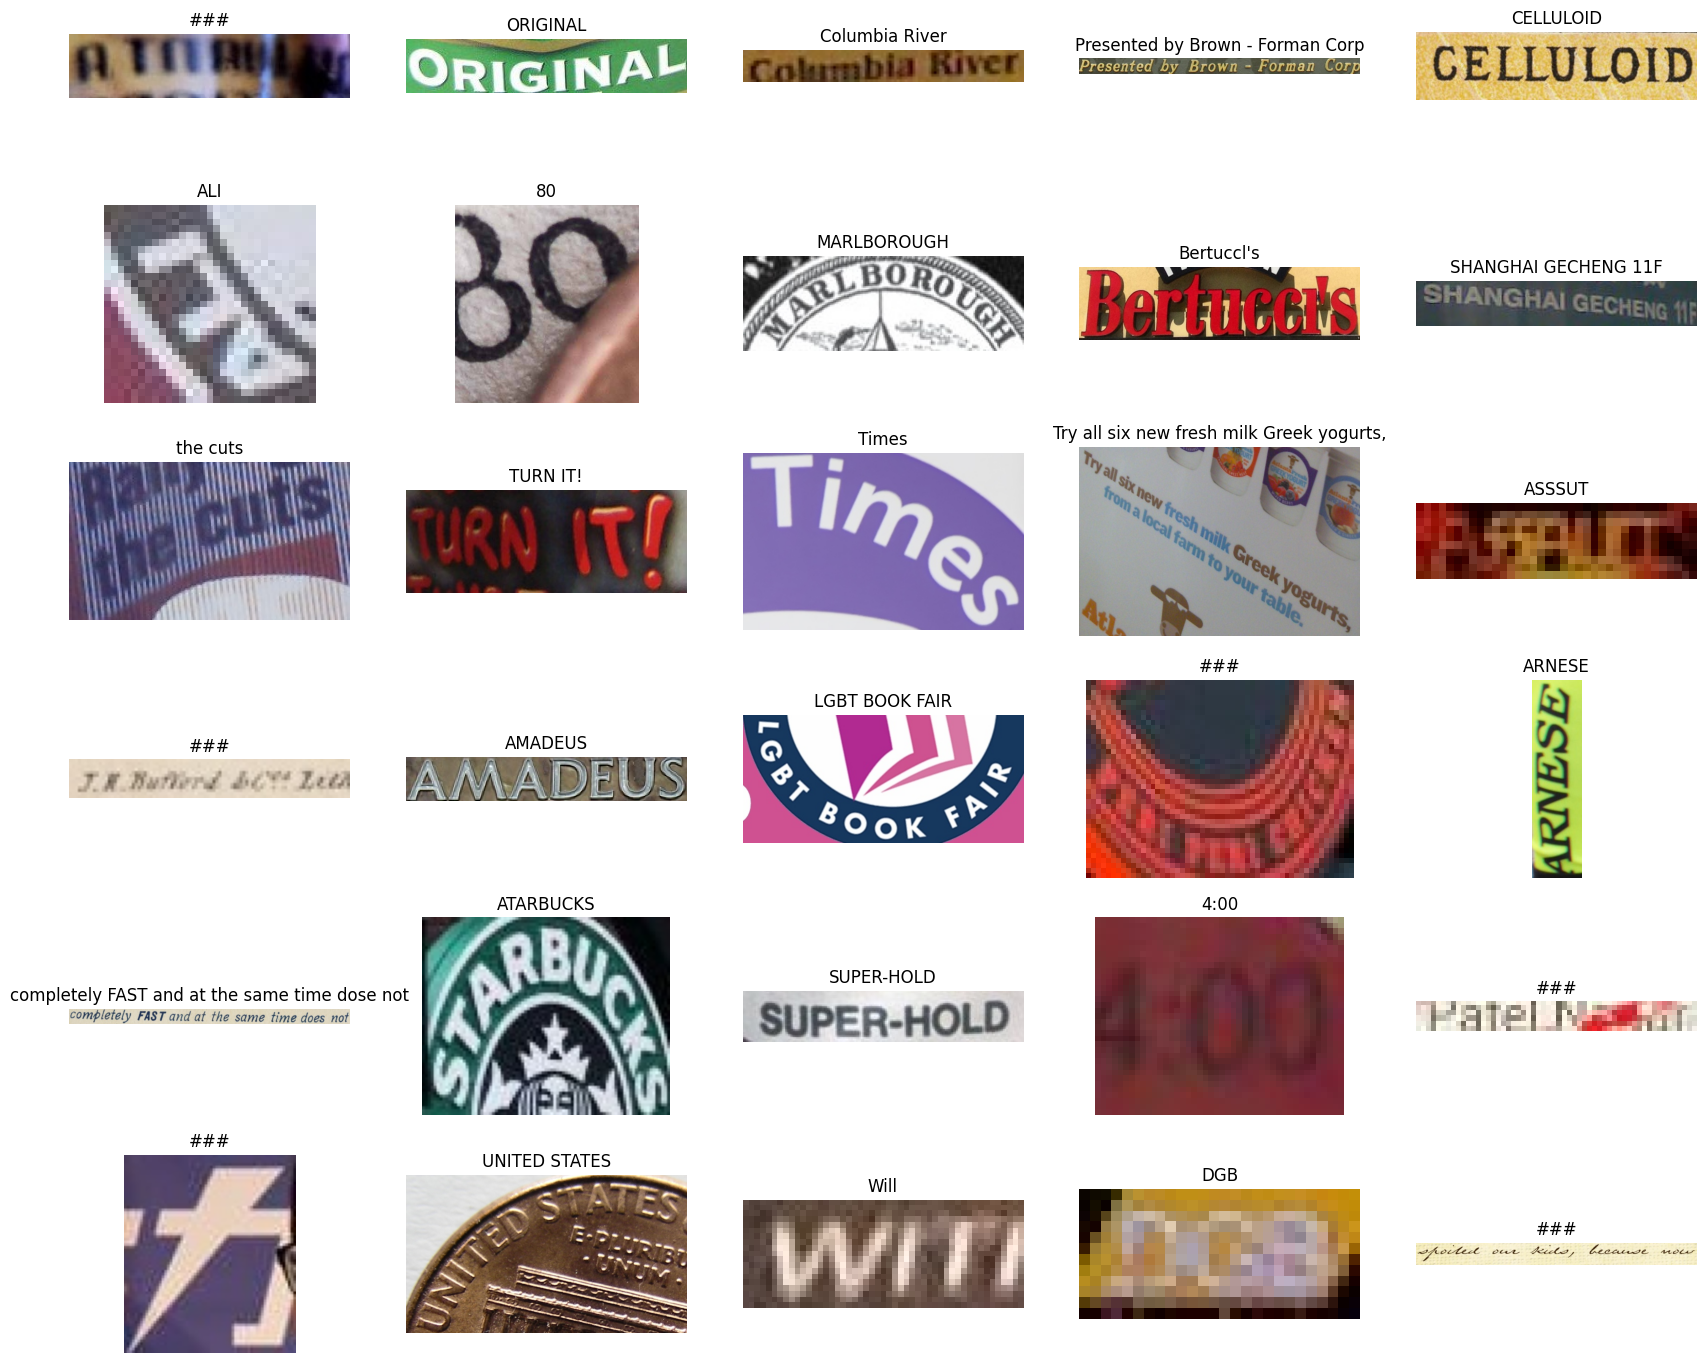

In [5]:
def read_labels(label_path: str):
    labels = {}

    with open(label_path, "r") as f:
        while line := f.readline():
            sp = line.split("\t")
            labels[sp[0]] = sp[1].strip("\n")

    return labels


def visualize(image_path: str, labels: dict[str, str], n=30):
    images = glob.glob(os.path.join(image_path, "*.jpg"))
    c = 5
    r = n // c

    plt.subplots(r, c, figsize=(21, 18))
    for j in range(0, n):
        i = random.randint(0, len(images))
        plt.subplot(r, c, j + 1)
        image = cv2.imread(images[i], cv2.IMREAD_COLOR)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            plt.axis("off")

            basename = os.path.basename(images[i])
            plt.title(labels[basename])


labels = read_labels(os.path.join(TrainingConfig.DATASET_DIR, "scut_data/scut_train.txt"))
visualize(os.path.join(TrainingConfig.DATASET_DIR, "scut_data/scut_train"), labels)

## Preprocess and Load the Dataset

In [6]:
processor = TrOCRProcessor.from_pretrained(
    "microsoft/trocr-base-printed",
    use_fast=True,
    cache_dir=TrainingConfig.CACHE_DIR,
)

In [7]:
def create_dataset(image_path: str, labels: dict[str, str]):
    images_path = glob.glob(os.path.join(image_path, "*.jpg"))

    targets = []

    for image_path in images_path:
        target = labels[os.path.basename(image_path)]
        targets.append(target)

    return Dataset.from_dict({"data": images_path, "labels": targets})

In [8]:
if not os.path.exists(os.path.join(TrainingConfig.DATASET_DIR, "proc_scut_data")):
    train_dataset = create_dataset(
        os.path.join(TrainingConfig.DATASET_DIR, "scut_data/scut_train"),
        labels=labels,
    )

    test_dataset = create_dataset(
        os.path.join(TrainingConfig.DATASET_DIR, "scut_data/scut_test"),
        labels=read_labels(
            os.path.join(TrainingConfig.DATASET_DIR, "scut_data/scut_test.txt")
        ),
    )

    def process_image(item):
        result = processor(item["data"], item["labels"], return_tensors="pt", padding="max_length", truncation=True, max_length=25)  # type: ignore
        result["pixel_values"] = result["pixel_values"].squeeze(0)
        result["labels"] = result["labels"].squeeze(0)
        return result

    train_dataset = (
        train_dataset.cast_column("data", HFImage())
        .map(process_image, num_proc=TrainingConfig.NUM_WORKERS)
        .with_format("torch")
    )

    test_dataset = (
        test_dataset.cast_column("data", HFImage())
        .map(process_image, num_proc=TrainingConfig.NUM_WORKERS)
        .with_format("torch")
    )

    train_dataset.save_to_disk(
        os.path.join(TrainingConfig.DATASET_DIR, "proc_scut_data", "train")
    )
    test_dataset.save_to_disk(
        os.path.join(TrainingConfig.DATASET_DIR, "proc_scut_data", "test")
    )

else:

    train_dataset = Dataset.load_from_disk(
        os.path.join(TrainingConfig.DATASET_DIR, "proc_scut_data", "train")
    )

    test_dataset = Dataset.load_from_disk(
        os.path.join(TrainingConfig.DATASET_DIR, "proc_scut_data", "test")
    )

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

## Load Model

In [9]:
model = VisionEncoderDecoderModel.from_pretrained(
    "microsoft/trocr-base-printed",
    cache_dir=TrainingConfig.CACHE_DIR,
)

# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id  # type: ignore
model.config.pad_token_id = processor.tokenizer.pad_token_id  # type: ignore


# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.eos_token_id  # type: ignore

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluation Metric Definition

In [10]:
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")


metric = evaluate.load("cer")


def evaluate_metrics(eval_pred: EvalPrediction, compute_result: bool = False) -> dict:
    logits, label_ids = eval_pred
    pred_str = processor.batch_decode(logits, skip_special_tokens=True)
    target = processor.batch_decode(label_ids, skip_special_tokens=True)  # type: ignore

    out = {
        "cer": metric.compute(predictions=pred_str, references=target),  # type: ignore
    }

    return out

## Training

In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(TrainingConfig.ROOT_DIR, "models", "ocr"),
    num_train_epochs=TrainingConfig.EPOCHS,
    learning_rate=TrainingConfig.LEARNING_RATE,
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    save_strategy="best",
    save_total_limit=3,
    load_best_model_at_end=True,
    batch_eval_metrics=False,
    logging_strategy="steps",
    logging_steps=25,
    eval_accumulation_steps=25,
    report_to=TrainingConfig.REPORT,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=evaluate_metrics,
)

results = trainer.train()

model.save_pretrained(os.path.join(TrainingConfig.ROOT_DIR, "models", "ocr"))

wandb: Currently logged in as: jmanuelc87 (jmanuelc87-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
25,2.751600
50,1.059300
75,0.833800
100,0.836200
125,0.735300
150,0.754800
175,0.730100
200,0.709300
225,0.683600
250,0.631400


## Inference

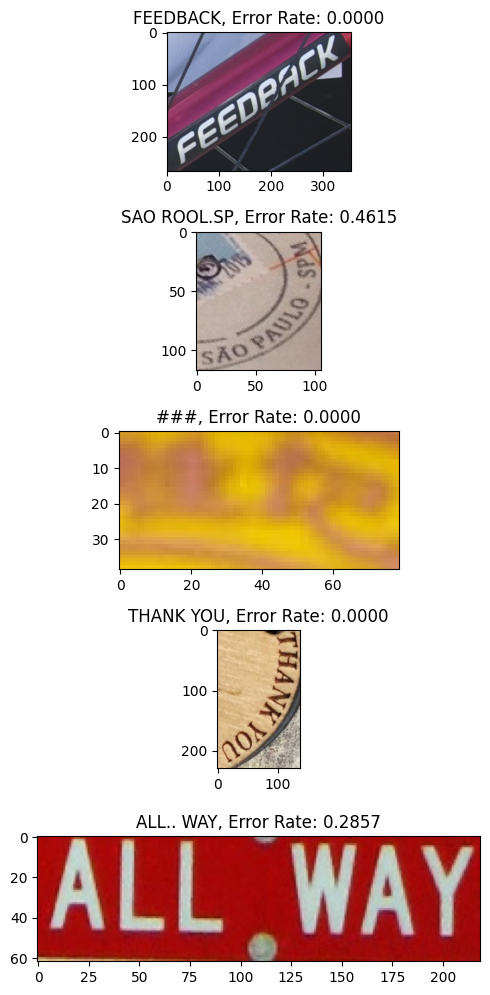

In [19]:
plt.subplots(5, 1, figsize=(5, 10))
for i in range(5):
    k = random.randint(0, len(test_dataset))
    outputs = model.generate(test_dataset[k]["pixel_values"].unsqueeze(0).to(get_default_device()))  # type: ignore

    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)

    evaluation = evaluate_metrics(
        EvalPrediction(predictions=outputs, label_ids=test_dataset[k]["labels"].unsqueeze(0))  # type: ignore
    )

    plt.subplot(5, 1, i + 1)
    plt.imshow(test_dataset[k]["data"].permute(1, 2, 0))
    plt.title(f"{pred_str[0]}, Error Rate: {evaluation["cer"]:.4f}")

plt.tight_layout()

## CER Metric Test Dataset

In [14]:
model = VisionEncoderDecoderModel.from_pretrained(
    os.path.join(TrainingConfig.ROOT_DIR, "models", "ocr")
).to(get_default_device())

metrics = []

it = test_dataset.remove_columns("data").batch(32)

for item in tqdm(it):
    output_ids = model.generate(item["pixel_values"].to(get_default_device()))  # type: ignore

    evaluation = evaluate_metrics(
        EvalPrediction(predictions=output_ids, label_ids=item["labels"])  # type: ignore
    )

    metrics.append(evaluation["cer"])

mean_cer = np.array(metrics).mean()

print(f"Mean CER Score: {mean_cer}")

100%|██████████| 52/52 [03:10<00:00,  3.65s/it]

Mean CER Score: 0.40281240475374064


In [15]:
import wandb

wandb.log({"mean_cer": mean_cer})

wandb.finish()

mean_cer,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,▃▆▂▄█▃▄▃▄▅▃▂▃▃▃▂▂▄▄▁▅▂▃▁▂▂▁▃▂▁▁▂▃▁▃▅▂▁▁▃
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_cer,0.40281
total_flos,2.264310987953799e+19
train/epoch,5
train/global_step,1265
train/grad_norm,6.27015
